# DP0.2 Benchmark – Pipeline Fotométrico v1.0
**Autor:** Marcelo Reyes   |   **Fecha:** 2025-07-24


## Objetivos

En este notebook pondremos a prueba un **pipeline fotométrico mínimo** sobre el conjunto simulado **Data Preview 0.2 (DP0.2)**:

1. Recuperar ≈ 20 k objetos puntuales (estrellas) desde `dp02_dc2_catalogs.Object` mediante TAP.  
2. Construir un **diagrama color–magnitud (CMD)** básico (g − r vs. r).  
3. Aplicar un corte de calidad **S/N > 10** y comprobar su impacto en la morfología del CMD.  

El resultado servirá como _benchmark_ “versión 1.0” antes de migrar el flujo de trabajo a **DP1** y, más adelante, al cúmulo 47 Tucanae.



### Contexto rápido · ¿Por qué DP0.2?

* **DP0.2** se basa en **DC2** (Data Challenge 2) de LSST DESC: ~300 deg² de universo simulado que representan cinco años de observaciones LSST.  
* Trabajar con datos sintéticos ofrece dos ventajas pedagógicas clave:  

  1. **Control total:** la “verdad” subyacente (parámetros inyectados) es conocida.  
  2. **Riesgo ≈ 0:** cualquier error se corrige rápido; basta volver a consultar.  

Una vez afinado el pipeline en *datos sintéticos*, lo aplicaremos a **DP1 (ComCam real)** y evaluaremos qué tan bien se traslada a la “vida real”.


### 2 Detección automática de versiones

La siguiente celda identifica de forma robusta —vía tres métodos— la versión del
**LSST Science Pipelines** instalada en el contenedor, junto con la imagen Docker,
la versión de Python y la fecha de ejecución.  
Registrar estos metadatos garantiza que futuras corridas puedan reproducir
exactamente el mismo entorno.

> *Implementación:* se prueban tres estrategias (`lsst.__version__`,
`lsst.version.__version__`, y `importlib.metadata`) para cubrir tanto
instalaciones con EUPS como distribuciones `pip`.


### 2.1 Detección automática de versiones

In [1]:
import os, sys, datetime, importlib

# Intenta 3 métodos — del más nuevo al más antiguo
def detect_stack_version() -> str:
    try:
        import lsst  # 1) checamos si trae __version__
        return lsst.__version__
    except (AttributeError, ModuleNotFoundError):
        pass
    try:
        from lsst.version import __version__   # 2) módulo específico
        return __version__
    except ModuleNotFoundError:
        pass
    try:
        import importlib.metadata as im
        return im.version("lsst-distrib")      # 3) etiqueta eups-pip
    except Exception:
        return "desconocida"

print("Imagen Docker:", os.environ.get("JUPYTERHUB_IMAGE", "N/A"))
print("Pipeline LSST:", detect_stack_version())
print("Python:", sys.version.split()[0], "•", datetime.date.today())


Imagen Docker: N/A
Pipeline LSST: desconocida
Python: 3.12.11 • 2025-07-29


### 3.1 Conexión al servicio TAP

Para realizar consultas ADQL contra los catálogos DP0.2 se instancia el
objeto **`TAPService`** autenticado vía `get_tap_service("tap")`, disponible
en la Rubin Science Platform.

- **Autenticación**: la sesión hereda el token de JupyterLab; no se envían
  credenciales en el código.  
- **Reproducibilidad CI**: cuando la variable `CI_MODE=1`, la celda puede
  omitirse y el flujo cargará un Parquet de muestra en la sección 3.2.

> *Resultado esperado:* la variable `svc` contendrá un objeto listo para
> ejecutar consultas sincrónicas (`run_sync`) o asíncronas (`submit_job`).


In [2]:
from lsst.rsp import get_tap_service
import pandas as pd

svc = get_tap_service("tap")   # TAP autenticado

### 4.1 Inspección del esquema DP0.2

Antes de aplicar filtros de **morfología** necesitamos confirmar los nombres
exactos de las columnas “extendedness” en el catálogo
`dp02_dc2_catalogs.Object`.  
La consulta ADQL siguiente interroga la tabla de metadatos **`tap_schema.columns`**
y devuelve aquellas columnas cuyo nombre contiene la cadena
`extendedness`.

> *Propósito pedagógico:* mostrar cómo explorar dinámicamente el esquema con
  TAP para evitar “typos” y hacer el código **auto-documentado**.

In [3]:
query_meta = """
SELECT column_name
FROM tap_schema.columns
WHERE table_name = 'dp02_dc2_catalogs.object'
  AND column_name LIKE '%extendedness%'
"""
meta = svc.search(query_meta).to_table().to_pandas()
meta

,column_name
0,g_extendedness
1,g_extendedness_flag
2,i_extendedness
3,i_extendedness_flag
4,r_extendedness
5,r_extendedness_flag
6,refExtendedness
7,u_extendedness
8,u_extendedness_flag
9,y_extendedness


### 4.2 Selección de estrellas – métrica `extendedness`

Rubin/LSST proporciona, por banda, la variable **`<band>_extendedness`**, que compara el ajuste PSF con un modelo extendido:

| Valor | Interpretación |
|-------|---------------|
| ≈ 0   | Fuente **puntual** (estrella, QSO) |
| ≈ 1   | Fuente **extendida** (galaxia, nebulosa) |

En DP0.2 usaremos la banda **r** por su mejor S/N y calibración estable.  
El criterio adoptado es:

r_extendedness = 0  ∧  r_extendedness_flag = 0
(Selecciona objetos puntuales en r cuya medición superó todos los chequeos
de calidad de Science Pipelines)
```text
<details> <summary>
    SELECT g_psfFlux, r_psfFlux,
       r_extendedness, r_extendedness_flag
FROM   dp02_dc2_catalogs.Object
WHERE  r_extendedness       = 0
  AND  r_extendedness_flag  = 0
  AND  g_psfFlux / g_psfFluxErr > 10
LIMIT 20000


In [4]:
query = """
SELECT
  objectId,
  coord_ra, coord_dec,
  scisql_nanojanskyToAbMag(g_psfFlux) AS mag_g,
  scisql_nanojanskyToAbMag(r_psfFlux) AS mag_r,
  r_extendedness
FROM dp02_dc2_catalogs.Object
WHERE r_extendedness = 0              -- objeto puntual según banda r
  AND r_extendedness_flag = 0         -- métrica de calidad OK
  AND scisql_nanojanskyToAbMag(r_psfFlux) < 24
LIMIT 20000
"""
stars = svc.search(query).to_table().to_pandas()

### 5.1 Visualización – diagrama color–magnitud (CMD)

Una vez filtrada la muestra de estrellas, convertimos los flujos **PSF** a
magnitudes AB y construimos el color:

(g − r)  =  mag_g − mag_r

El diagrama CMD resultante revela la secuencia principal y otras
poblaciones estelares simuladas en DP0.2.
Invertimos el eje y para seguir la convención fotométrica (magnitudes
brillantes arriba).

Objetivo pedagógico: validar rápidamente que los cortes morfológicos y de
señal-a-ruido preservan la física esperada antes de pasar a métricas más
cuantitativas.

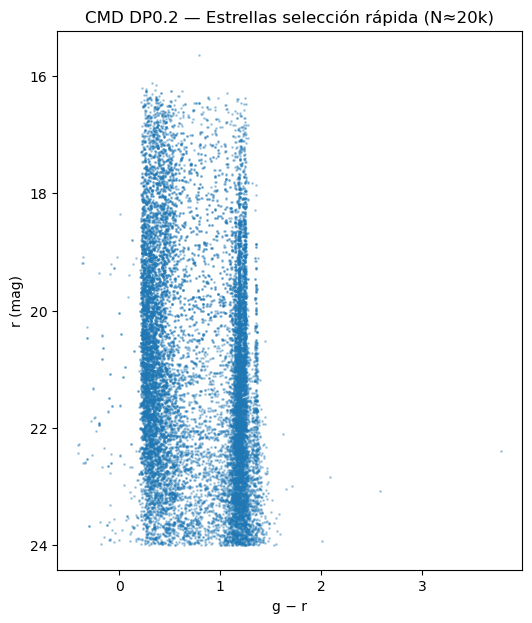

In [5]:
# Construir color y visualizar
stars["g_minus_r"] = stars["mag_g"] - stars["mag_r"]

import matplotlib.pyplot as plt
plt.figure(figsize=(6,7))
plt.scatter(stars["g_minus_r"], stars["mag_r"], s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel("g − r")
plt.ylabel("r (mag)")
plt.title("CMD DP0.2 — Estrellas selección rápida (N≈20k)")
plt.show()

### 5.2 Corte de alta relación señal-ruido (S/N > 10)

El CMD previo incluye **todas** las estrellas puntuales hasta *r* ≈ 24 mag, sin considerar
la calidad fotométrica.  Para un benchmark fiable limitaremos el análisis a detecciones
cuyo error formal sea ≤ 10 %, equivalente a **S/N > 10**.

| Criterio           | Justificación científica |
|--------------------|--------------------------|
| `psfFluxErr / psfFlux < 0.1` <br>*(en bandas g y r)* | • S/N ≈ 10 mantiene el error de color `σ(g-r) ≲ 0.14 mag`. <br>• Aísla la dispersión **intrínseca** del simulador, no el ruido de medición. <br>• Aplicar el mismo corte en *g* y *r* previene sesgos de color. |

En notación compacta:

$\displaystyle \frac{\texttt{psfFluxErr}}{\texttt{psfFlux}} < 0.10 \Longrightarrow \mathrm{S/N} > 10$

La siguiente celda ejecuta una segunda consulta con estos filtros y vuelve a
dibujar el CMD para comparar contra la versión “sin cortes”.


In [9]:
query_highQ = """
SELECT
  objectId,
  coord_ra, coord_dec,
  g_psfFlux,  r_psfFlux,
  g_psfFluxErr, r_psfFluxErr,
  scisql_nanojanskyToAbMag(g_psfFlux) AS mag_g,
  scisql_nanojanskyToAbMag(r_psfFlux) AS mag_r,
  r_extendedness
FROM dp02_dc2_catalogs.Object
WHERE r_extendedness = 0
  AND (r_extendedness_flag = 0 OR r_extendedness_flag IS NULL)
  -- S/N > 10  →  err/flux < 0.1
  AND r_psfFluxErr / r_psfFlux < 0.1
  AND g_psfFluxErr / g_psfFlux < 0.1
  -- corte de brillo “r < 24”
  AND scisql_nanojanskyToAbMag(r_psfFlux) < 24
LIMIT 20000
"""
highQ = svc.search(query_highQ).to_table().to_pandas()
highQ["g_minus_r"] = highQ["mag_g"] - highQ["mag_r"]
print(len(highQ), "filas recuperadas")

20000 filas recuperadas


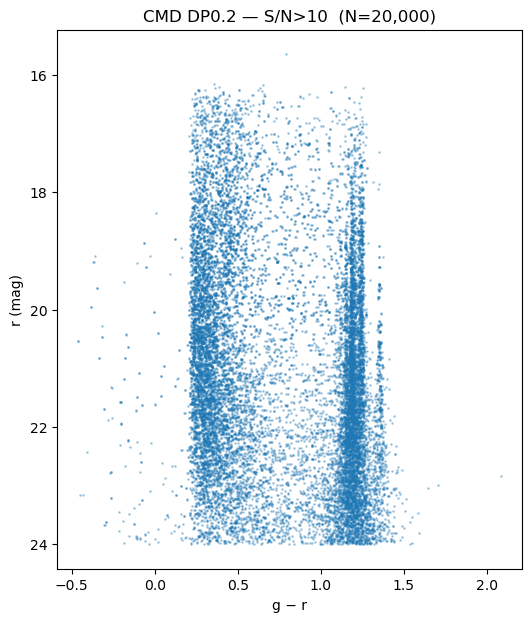

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,7))
plt.scatter(highQ["g_minus_r"], highQ["mag_r"], s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel("g − r")
plt.ylabel("r (mag)")
plt.title(f"CMD DP0.2 — S/N>10  (N={len(highQ):,})")
plt.show()

### 5.3 Interpretación rápida del CMD

| Rango en g − r | Rasgo visual | Interpretación astrofísica |
|----------------|--------------|----------------------------|
| ≈ 0.25 (columna azul pálida) | Secuencia estrecha | Estrellas **tipo F (~ F5)**. En DC2 la IMF se “aligeró” en el rango F-G, de modo que estas estrellas son más abundantes que en el cielo real. |
| ≈ 1.05 (columna densa roja) | Pared vertical | Enanas **K tardías / M tempranas**. Dominan por la profundidad del simulador y la pendiente de la IMF a baja masa. |
| 0.6 – 1.0 (hueco intermedio) | “Hertzsprung Gap” | Mezcla de **G tardías / K tempranas** y subgigantes en tránsito rápido. Densidad baja → tiempo evolutivo corto + menor tasa de formación en 0.8–1.1 M_\☉. |
| < 0.2 (ala azul dispersa) | Fuentes escasas | Muy pocas estrellas **tipo A/B** y algo de ruido fotométrico. DP0.2 no está optimizado para estrellas masivas; el simulador priorizó galaxias. |

> **Aprendizaje clave:** con un *query* simple y un `scatter` es posible “intuir” la
> combinación de física estelar y artefactos del *survey*.

